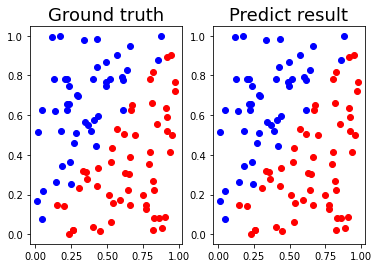

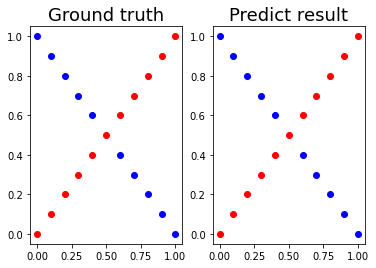

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import logging
import argparse
log_filename = datetime.datetime.now().strftime("log/%Y-%m-%d_%H_%M_%S.log")
os.makedirs(os.path.dirname(log_filename), exist_ok=True)
logging.basicConfig(level=logging.DEBUG,
                 format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                 datefmt='%m-%d %H:%M:%S',
                 filename=log_filename)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

def sigmoid(x):
    pass

def derivative_sigmoid(x):
    pass

def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue

        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.show()

x, y = generate_linear()
show_result(x, y, y)
x, y = generate_XOR_easy()
show_result(x, y, y)